# Raw data visualization
This notebook is to show you how to visualize the data that we are inputing into the model.

The raw data is contained in `MDSINE2_Paper/datasets/gibson`. 

The pickle files that you need will be in the directory `MDSINE2_Paper/processed_data`. This processing is used to collapse the ASVs into OTUs, perform alignments, phylogenetic placements, and taxonomy assignment.



This tutorial is about working with and visualizing our data and getting it ready for inference. For your data, you can go onto the next tutorial.

In [1]:
%matplotlib inline

import mdsine2 as md2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys

In [2]:
# Loading in the preprocessed healthy pickle
healthy = md2.Study.load('../analysis/output/gibson/preprocessed/gibson_healthy_agg_taxa.pkl')
uc = md2.Study.load('../analysis/output/gibson/preprocessed/gibson_uc_agg_taxa.pkl')


print('Healthy')
for subj in healthy:
    print(subj.name)
for perturbation in healthy.perturbations:
    print(perturbation)
print('Ulcerative Colitis')
for subj in uc:
    print(subj.name)
for perturbation in uc.perturbations:
    print(perturbation)


Healthy
2
3
4
5
Perturbation High Fat Diet:
	Subject 2: (21.5, 28.5)
	Subject 3: (21.5, 28.5)
	Subject 4: (21.5, 28.5)
	Subject 5: (21.5, 28.5)

Perturbation Vancomycin:
	Subject 2: (35.5, 42.5)
	Subject 3: (35.5, 42.5)
	Subject 4: (35.5, 42.5)
	Subject 5: (35.5, 42.5)

Perturbation Gentamicin:
	Subject 2: (50.5, 57.5)
	Subject 3: (50.5, 57.5)
	Subject 4: (50.5, 57.5)
	Subject 5: (50.5, 57.5)

Ulcerative Colitis
10
6
7
8
9
Perturbation High Fat Diet:
	Subject 6: (21.5, 28.5)
	Subject 7: (21.5, 28.5)
	Subject 8: (21.5, 28.5)
	Subject 9: (21.5, 28.5)
	Subject 10: (21.5, 28.5)

Perturbation Vancomycin:
	Subject 6: (35.5, 42.5)
	Subject 7: (35.5, 42.5)
	Subject 8: (35.5, 42.5)
	Subject 9: (35.5, 42.5)
	Subject 10: (35.5, 42.5)

Perturbation Gentamicin:
	Subject 6: (50.5, 57.5)
	Subject 7: (50.5, 57.5)
	Subject 8: (50.5, 57.5)
	Subject 9: (50.5, 57.5)
	Subject 10: (50.5, 57.5)



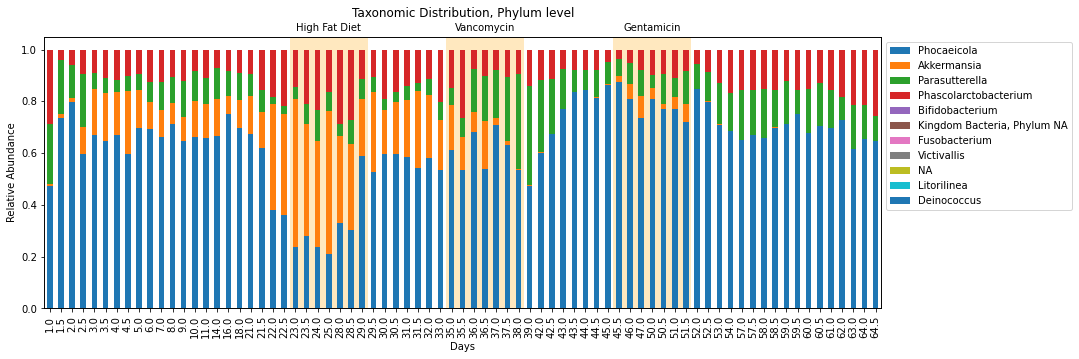

In [3]:
# Make the taxonomic abundance of a subject
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
md2.visualization.taxonomic_distribution_over_time(healthy['2'], taxlevel='phylum', label_formatter='%(phylum)s', ax=ax)

plt.show()

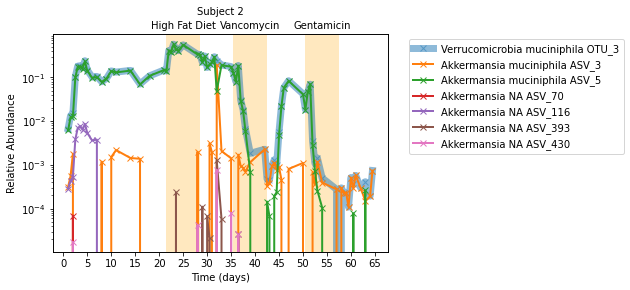

In [4]:
# Visualize the collapse of an OTU
ax = md2.visualization.aggregate_taxa_abundances(subj=healthy['2'], agg=healthy.taxa['OTU_3'])
plt.show()
# We have a script that does this over every subject for every OTU. Run the bash command `./../gibson_dataset/plot_aggregates.sh`

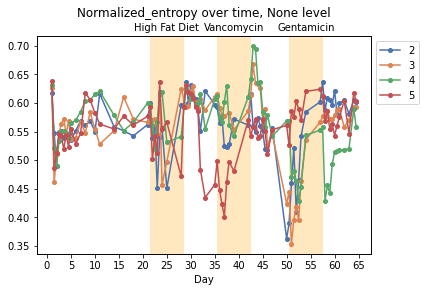

In [5]:
# Alpha diversity
md2.visualization.alpha_diversity_over_time([subj for subj in healthy], 
    metric=md2.diversity.alpha.normalized_entropy)
plt.show()

In [6]:
# SAWAL recreate supplemental figures that you can

In [7]:
# Sawal recreate main figures that you can

In [8]:
# Filtering
# Use consistency filtering
print('Number of OTUs before', len(healthy.taxa))
healthy_filt = md2.consistency_filtering(healthy, dtype='rel',
    threshold=0.0001,
    min_num_consecutive=7,
    min_num_subjects=2,
    colonization_time=5)
print('Number of OTUs after', len(healthy_filt.taxa))

Number of OTUs before 1224
Number of OTUs after 113


113
2021-07-02 19:25:32,563 [INFO] [inference.py (591)] - Setting Single Write, Multiple Read Mode
2021-07-02 19:25:32,563 [INFO] [inference.py (596)] - Setting the trace of learned parameters
2021-07-02 19:25:32,563 [INFO] [inference.py (597)] - #######################################
2021-07-02 19:25:32,563 [INFO] [inference.py (599)] - Setting the trace of Negative binomial dispersion a0
2021-07-02 19:25:32,567 [INFO] [inference.py (599)] - Setting the trace of Negative binomial dispersion a1
2021-07-02 19:25:32,572 [INFO] [inference.py (599)] - Setting the trace of Filtering
2021-07-02 19:25:32,583 [INFO] [inference.py (601)] - Setting the trace for diagnostic variables
2021-07-02 19:25:32,583 [INFO] [inference.py (602)] - ##########################################
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


NOTE these are from a short run. full model runs are much longer
Learned a0 2.2821697174155757e-10
Learned a1 0.06003916687372822


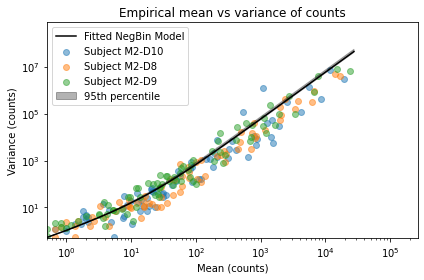

In [9]:
# Negative binomial
# load replicates
reps =  md2.Study.load('../analysis/output/gibson/preprocessed/gibson_replicates_agg_taxa.pkl')
# Filter like healthy
to_delete = []
for taxon in reps.taxa:
    if taxon.name not in healthy_filt.taxa:
        to_delete.append(taxon.name)
reps.pop_taxa(to_delete)
print(len(reps.taxa))

# Load parameters, basepath is a temporary folder because we will run the shell scripts to generate our actual data
params = md2.config.NegBinConfig(seed=0, burnin=100, n_samples=200, checkpoint=100, 
                                 basepath='output/negbin')

# Build the graph
mcmc = md2.negbin.build_graph(params=params, graph_name='test negbin', subjset=reps)

# Run inference
mcmc = md2.negbin.run_graph(mcmc, crash_if_error=True)

# Visualize the fit
fig = md2.negbin.visualize_learned_negative_binomial_model(mcmc)
fig.tight_layout()

from mdsine2.names import STRNAMES
print('NOTE these are from a short run. full model runs are much longer')
print('Learned a0', md2.summary(mcmc.graph[STRNAMES.NEGBIN_A0])['mean'])
print('Learned a1', md2.summary(mcmc.graph[STRNAMES.NEGBIN_A1])['mean'])

# Run scripts
These scripts mirror our shell scripts in the folder `MDSINE2_Paper/gibson_dataset` but we modify them to be shorter runs that what is done in the actual scripts. The purpose of these is for you to see what is going on within the scripts.

In [10]:
# Assign taxonomy to consensus sequences
# This is called in the script MDSINE2_Paper/gibson_dataset/preprocess_assign_consensus_taxonomy.sh
!python ../analysis/helpers/assign_taxonomy_for_consensus_seqs.py \
    --rdp-table ../analysis/files/assign_taxonomy_OTUs/taxonomy_RDP.txt \
    --confidence-threshold 50 \
    --output-basepath ../analysis/output/gibson/preprocessed

2021-07-02 19:25:38,962 [INFO] [assign_taxonomy_for_consensus_seqs.py (87)] - Parsing RDP
2021-07-02 19:25:38,967 [INFO] [assign_taxonomy_for_consensus_seqs.py (91)] - Replacing healthy
2021-07-02 19:25:39,557 [INFO] [assign_taxonomy_for_consensus_seqs.py (91)] - Replacing uc
2021-07-02 19:25:40,243 [INFO] [assign_taxonomy_for_consensus_seqs.py (91)] - Replacing replicates
2021-07-02 19:25:40,282 [INFO] [assign_taxonomy_for_consensus_seqs.py (91)] - Replacing inoculum


OTU_66 taxonomy does not agree
OTU
	id: 2508642720008
	idx: 65
	name: OTU_66
	Aggregates: ['ASV_88', 'ASV_121']
	taxonomy:
		kingdom: Bacteria
		phylum: Firmicutes
		class: Clostridia
		order: Clostridiales
		family: Lachnospiraceae
		genus: Enterocloster
		species: NA
OTU_85 taxonomy does not agree
OTU
	id: 2508643084720
	idx: 84
	name: OTU_85
	Aggregates: ['ASV_115', 'ASV_124']
	taxonomy:
		kingdom: Bacteria
		phylum: Firmicutes
		class: Clostridia
		order: Clostridiales
		family: Ruminococcaceae
		genus: Fournierella
		species: NA
OTU_93 taxonomy does not agree
OTU
	id: 2508643175448
	idx: 92
	name: OTU_93
	Aggregates: ['ASV_130', 'ASV_205', 'ASV_326', 'ASV_407']
	taxonomy:
		kingdom: Bacteria
		phylum: Firmicutes
		class: Clostridia
		order: Clostridiales
		family: Lachnospiraceae
		genus: Roseburia
		species: faecis
OTU_114 taxonomy does not agree
OTU
	id: 2508643215232
	idx: 113
	name: OTU_114
	Aggregates: ['ASV_159', 'ASV_291', 'ASV_233', 'ASV_347']
	taxonomy:
		kingdom: Bacteri

In [11]:
# plot the agglom
# Takes approximately <1 minute to plot everything in this cell
# This is called in the script MDSINE2_Paper/gibson_dataset/plot_aggregates.sh
# This produces a folder in MDSINE2_Paper/output/aggregate_plots
!python ../analysis/helpers/plot_otus.py \
    --study ../analysis/output/gibson/preprocessed/gibson_healthy_agg_taxa.pkl \
    --output-basepath ../analysis/output/gibson/plots/aggregate_plots/ \
    --top 10
!python ../analysis/helpers/plot_otus.py \
    --study ../analysis/output/gibson/preprocessed/gibson_uc_agg_taxa.pkl \
    --output-basepath ../analysis/output/gibson/plots/aggregate_plots/ \
    --top 10

2021-07-02 19:25:42,042 [INFO] [plot_otus.py (34)] - Subject 2
2021-07-02 19:25:42,042 [INFO] [plot_otus.py (40)] - taxon 0/1224
2021-07-02 19:25:42,403 [INFO] [plot_otus.py (40)] - taxon 1/1224
2021-07-02 19:25:42,646 [INFO] [plot_otus.py (40)] - taxon 2/1224
2021-07-02 19:25:42,899 [INFO] [plot_otus.py (40)] - taxon 3/1224
2021-07-02 19:25:43,102 [INFO] [plot_otus.py (40)] - taxon 4/1224
2021-07-02 19:25:43,373 [INFO] [plot_otus.py (40)] - taxon 5/1224
2021-07-02 19:25:43,574 [INFO] [plot_otus.py (40)] - taxon 6/1224
2021-07-02 19:25:43,796 [INFO] [plot_otus.py (40)] - taxon 7/1224
2021-07-02 19:25:43,998 [INFO] [plot_otus.py (40)] - taxon 8/1224
2021-07-02 19:25:44,203 [INFO] [plot_otus.py (40)] - taxon 9/1224
2021-07-02 19:25:44,482 [INFO] [plot_otus.py (34)] - Subject 3
2021-07-02 19:25:44,482 [INFO] [plot_otus.py (40)] - taxon 0/1224
2021-07-02 19:25:44,704 [INFO] [plot_otus.py (40)] - taxon 1/1224
2021-07-02 19:25:44,943 [INFO] [plot_otus.py (40)] - taxon 2/1224
2021-07-02 19:25

In [12]:
# plot subtrees
# This takes approximately 1.5 minutes
# This is called in the script MDSINE2_Paper/gibson_dataset/plot_phylogenetic_subtrees.sh
# This produces a folder in MDSINE2_Paper/output/subtrees
!python ../analysis/helpers/plot_phylogenetic_subtrees.py \
    --study ../analysis/output/gibson/preprocessed/gibson_healthy_agg_taxa.pkl \
    --output-basepath ../analysis/output/gibson/phylogeny/ \
    --tree ../analysis/files/phylogenetic_placement_OTUs/phylogenetic_tree_full_taxid.nhx \
    --seq-info ../analysis/files/subtrees/RDP-11-5_BA_TS_info.tsv \
    --sep \t \
    --family-radius-factor 1.5 \
    --top 20

2021-07-02 19:26:05,922 [INFO] [plot_phylogenetic_subtrees.py (39)] - Making distance matrix (this may take a minute)
2021-07-02 19:26:40,847 [INFO] [plot_phylogenetic_subtrees.py (46)] - Read sequence info file
2021-07-02 19:26:40,863 [INFO] [plot_phylogenetic_subtrees.py (49)] - get families of reference seqs
2021-07-02 19:26:40,913 [INFO] [plot_phylogenetic_subtrees.py (68)] - 0/1224 - nan
family is not defined for OTU_48
family is not defined for OTU_71
family is not defined for OTU_88
2021-07-02 19:26:40,964 [INFO] [plot_phylogenetic_subtrees.py (68)] - 100/1224 - 0.6096580723567278
family is not defined for OTU_151
family is not defined for OTU_152
family is not defined for OTU_159
family is not defined for OTU_164
family is not defined for OTU_167
2021-07-02 19:26:41,023 [INFO] [plot_phylogenetic_subtrees.py (68)] - 200/1224 - 0.621202761478475
family is not defined for OTU_201
family is not defined for OTU_213
family is not defined for OTU_230
family is not defined for OTU_235


In [13]:
# Filter the OTUs using consistency filtering
# This is called in the script MDSINE2_Paper/gibson_dataset/preprocessing_filtering.sh
!python ../analysis/helpers/step_2_filtering.py \
    --dataset ../analysis/output/gibson/preprocessed/gibson_healthy_agg_taxa.pkl \
    --outfile ../analysis/output/gibson/preprocessed/gibson_healthy_agg_taxa_filtered.pkl \
    --dtype rel \
    --threshold 0.0001 \
    --min-num-consecutive 7 \
    --min-num-subjects 2 \
    --colonization-time 5
!python ../analysis/helpers/step_2_filtering.py \
    --dataset ../analysis/output/gibson/preprocessed/gibson_uc_agg_taxa.pkl \
    --outfile ../analysis/output/gibson/preprocessed/gibson_uc_agg_taxa_filtered.pkl \
    --dtype rel \
    --threshold 0.0001 \
    --min-num-consecutive 7 \
    --min-num-subjects 2 \
    --colonization-time 5

# Learn negative binomial dispersion parameters
!python ../analysis/helpers/filter_replicates_like_other_dataset.py \
    --replicate-dataset ../analysis/output/gibson/preprocessed/gibson_replicates_agg_taxa.pkl \
    --like-other ../analysis/output/gibson/preprocessed/gibson_healthy_agg_taxa_filtered.pkl \
    --output-basepath ../analysis/output/gibson/preprocessed/gibson_replicates_agg_taxa_filtered.pkl


113 taxa left in healthy
94 taxa left in uc


In [14]:
# negbin
# This is called in the script MDSINE2_Paper/gibson_dataset/learn_negbin.sh
# This produces a folder in MDSINE2_Paper/output/negbin

!python ../analysis/helpers/step_3_infer_negbin.py \
    --input ../analysis/output/gibson/preprocessed/gibson_replicates_agg_taxa_filtered.pkl \
    --seed 0 \
    --burnin 100 \
    --n-samples 200 \
    --checkpoint 100 \
    --multiprocessing 0 \
    --basepath ../analysis/output/gibson/negbin

2021-07-02 19:26:59,798 [INFO] [inference.py (591)] - Setting Single Write, Multiple Read Mode
2021-07-02 19:26:59,798 [INFO] [inference.py (596)] - Setting the trace of learned parameters
2021-07-02 19:26:59,798 [INFO] [inference.py (597)] - #######################################
2021-07-02 19:26:59,798 [INFO] [inference.py (599)] - Setting the trace of Negative binomial dispersion a0
2021-07-02 19:26:59,803 [INFO] [inference.py (599)] - Setting the trace of Negative binomial dispersion a1
2021-07-02 19:26:59,803 [INFO] [inference.py (599)] - Setting the trace of Filtering
2021-07-02 19:26:59,818 [INFO] [inference.py (601)] - Setting the trace for diagnostic variables
2021-07-02 19:26:59,818 [INFO] [inference.py (602)] - ##########################################

100%|##########| 200/200 [00:03<00:00, 58.99it/s]
2021-07-02 19:27:03,212 [INFO] [inference.py (510)] - Inference total time: 0.016974332332611083/Gibb step
2021-07-02 19:27:03,212 [INFO] [inference.py (514)] - remove local